2025-06-30 14:31:04.962680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751293865.144836      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751293865.196573      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751293987.252305      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Training with SGD...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5


I0000 00:00:1751294007.753158      59 service.cc:148] XLA service 0x7e71e4004070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751294007.753858      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751294009.108100      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.1204 - loss: 2.5355

I0000 00:00:1751294012.300054      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.1053 - loss: 2.4301 - val_accuracy: 0.1019 - val_loss: 7.5946
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.0940 - loss: 2.7322 - val_accuracy: 0.0990 - val_loss: 7.6719
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.0877 - loss: 2.7705 - val_accuracy: 0.1004 - val_loss: 7.4606
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.1031 - loss: 2.7287 - val_accuracy: 0.1019 - val_loss: 7.4775
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.0997 - loss: 2.7153 - val_accuracy: 0.1004 - val_loss: 7.6367

Training with SGD_Nesterov...
Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.1037 - loss: 3.6698 - val_accuracy: 0.0961 - val_loss: 15.0095
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.1051 - loss: 4.9218 - val_accuracy: 0.1019 - val_loss: 14.9392
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.1024 - loss: 5.4089 - val_a

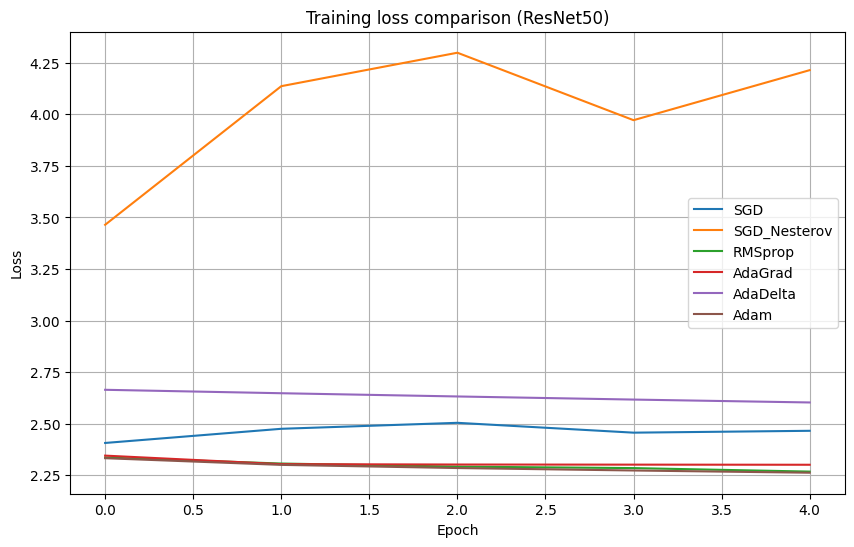

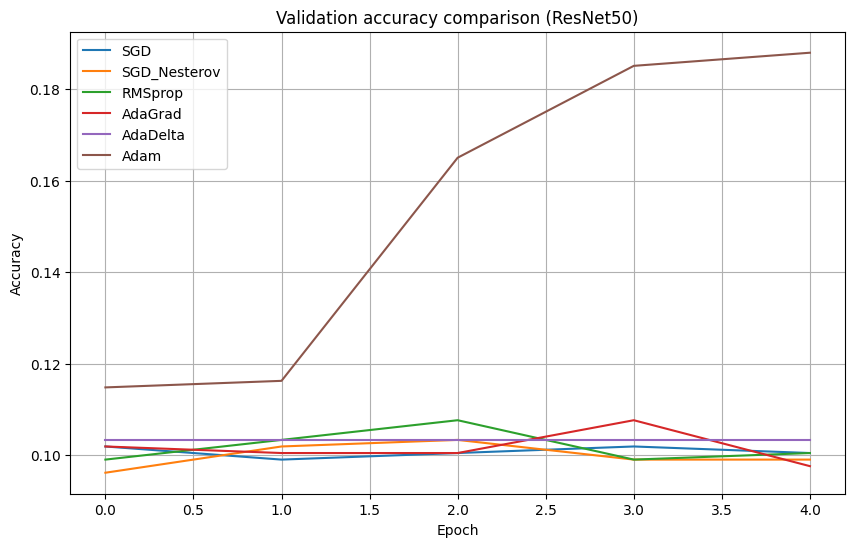

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import cv2

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

# ======= Load dữ liệu custom =======
def load_dataset_from_dir(data_dir, img_size=(224, 224)):
    X, y = [], []
    classes = sorted(d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)))
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(cls_dir, fname))
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0
                X.append(img)
                y.append(cls)
    return np.array(X), np.array(y), classes

# Đường dẫn data
dataset_path_train = '/kaggle/input/cus-hand-written/hand_written_digit/train'
dataset_path_test = '/kaggle/input/cus-hand-written/hand_written_digit/test'

X_train, y_train, label_map_train = load_dataset_from_dir(dataset_path_train, img_size=(224,224))
X_test, y_test, label_map_test = load_dataset_from_dir(dataset_path_test, img_size=(224,224))

le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.fit_transform(y_test)
num_classes = len(le.classes_)

# Chia tập train-valid
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train_num, test_size=0.2, random_state=42, stratify=y_train_num
)

# One-hot encode
Y_train = to_categorical(y_train_sub, num_classes)
Y_val = to_categorical(y_val, num_classes)
Y_test = to_categorical(y_test, num_classes)

# ======= Hàm build model ResNet50 + head mới =======
def build_resnet50_model(input_shape, num_classes):
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in resnet.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(resnet.output)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='fc' + str(num_classes),
                   kernel_initializer=glorot_uniform(seed=0))(x)

    model = Model(inputs=resnet.input, outputs=output)
    return model

# ======= Danh sách optimizer cần so sánh =======
optimizers = {
    'SGD': SGD(),
    'SGD_Nesterov': SGD(nesterov=True, momentum=0.9),
    'RMSprop': RMSprop(),
    'AdaGrad': Adagrad(),
    'AdaDelta': Adadelta(),
    'Adam': Adam()
}

history_dict = {}

# ======= Huấn luyện từng optimizer =======
for opt_name, opt in optimizers.items():
    print(f"\nTraining with {opt_name}...")
    model = build_resnet50_model((224, 224, 3), num_classes)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train_sub, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=32,
        epochs=5,
        verbose=1,
    )
    history_dict[opt_name] = history.history

print("✅ Training completed for all optimizers.")

# ======= Plot so sánh training loss =======
plt.figure(figsize=(10,6))
for opt_name, hist in history_dict.items():
    plt.plot(hist['loss'], label=opt_name)
plt.title('Training loss comparison (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ======= Plot so sánh validation accuracy =======
plt.figure(figsize=(10,6))
for opt_name, hist in history_dict.items():
    plt.plot(hist['val_accuracy'], label=opt_name)
plt.title('Validation accuracy comparison (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
